In [1]:
%reset -f
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import re, sqlite3, pickle, time, datetime, random, sys
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves

pd.options.display.float_format = '{:,.3f}'.format

# 0. Functions 

### 0.1. Encoding functions

In [2]:
############################################################
# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER OR NORMALISE CONTINUOUS VARIABLES
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
############################################################
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod, df
############################################################
def Normalise_n_encode_train_set(X_data, feat_list, data_types):
    encoder = []
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        feat_ = feat.replace("_Peak","")
        feat_ = feat_.replace("_Trough","")
        
        if data_types[feat_] == 'Continuous':
            X_data_feat = X_data[feat]
            mean        = X_data_feat.mean()
            std         = X_data_feat.std()
            X_data_norm_2[feat] = (X_data_feat - mean)/std
            encoder.append([feat, data_types[feat_], [mean, std]])
            
        elif data_types[feat_] == 'Categorical':
            X_data_norm_2[feat],df = target_encoder_Binary(feat, 'Mortality', X_data)
            encoder.append([feat, data_types[feat_], df])
            
        elif data_types[feat_] == 'Binary':
            X_data_norm_2[feat] = X_data[feat].copy()
            encoder.append([feat, data_types[feat_], ""])
    encoder =pd.DataFrame(encoder, columns = ['feature','type','parameters'])
    return X_data_norm_2,encoder
############################################################
def Normalise_n_encode_val_set(val_data, norm_encoder, feat_list, data_types):
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:        
        feat_encode = norm_encoder[norm_encoder['feature'] == feat].iloc[0]
        if feat_encode['type'] == 'Continuous':
            X_data_feat = val_data[feat]
            mean, std   = feat_encode['parameters']
            X_data_norm_2[feat] = (X_data_feat - mean)/std

        elif feat_encode['type'] == 'Categorical':
            df = feat_encode['parameters']
            X_data_norm_2[feat] = val_data[feat].map(dict(zip(df.index, df['prob'])))
            X_data_norm_2[feat] = X_data_norm_2[feat].fillna(0)
        elif feat_encode['type'] == 'Binary':
            X_data_norm_2[feat] = val_data[feat].copy()
    return X_data_norm_2
############################################################

### 0.2. Split Data Function

In [3]:
def train_valid_sets(X_train_set, X_valid_set):
    #######################################
    ### SPLIT DATA
    #######################################
    train_set = X_train_set
    valid_set = X_valid_set

    print('total admissions 16 18', len(X_train_set))
    print('total admissions 19 20', len(X_valid_set))
    print('X_train', len(train_set))
    print('Admissions neg (mortal - class = 0):', len(train_set[train_set['Mortality']==0]),
          'Admissions pos (recover- class = 1):', len(train_set[train_set['Mortality']==1]))
    print('X_valid', len(valid_set))
    print('Admissions neg (mortal - class = 0):', len(valid_set[valid_set['Mortality']==0]), 
          'Admissions pos (recover- class = 1):', len(valid_set[valid_set['Mortality']==1]))
    return train_set, valid_set

### 0.3. Encoding Data Function

In [4]:
def encoding_data(train_set, valid_set, feat_list, data_types):
    ############################################################
    train_set_norm, encoder = Normalise_n_encode_train_set(train_set, feat_list, data_types)
    valid_set_norm          = Normalise_n_encode_val_set(valid_set, encoder, feat_list, data_types)
    print("==========================================================================================================")
    print('----------------------------------TRAIN SET---------------------------------------------------------------')
    print("==========================================================================================================")
    display(train_set.head(4))
    display(train_set_norm.head(4))
    print("==========================================================================================================")
    print('----------------------------------VALIDATION SET----------------------------------------------------------')
    print("==========================================================================================================")
    display(valid_set.head(4))
    display(valid_set_norm.head(4))
    display(encoder)
    return train_set_norm, valid_set_norm, encoder

# 1. Load Data

In [5]:
t = time.time()
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'

X_data_16_18 = pickle.load(open(path + 'df_pnt_curb_2016_18.pickle','rb'))
X_data_19_20 = pickle.load(open(path + 'df_pnt_curb_2019_20.pickle','rb'))


print("=================================FIRST RECORDED SAMPLE ADMISSION=================================")
print("-------------------------------------- 2016 - 2018 ----------------------------------------------")
display(X_data_16_18[0].head(3))
print("")
print("-------------------------------------- 2019 - 2020 ----------------------------------------------")
display(X_data_19_20[0].head(3))

print("Elapsed time:", time.time()-t)

=================================FIRST RECORDED SAMPLE ADMISSION=================================
-------------------------------------- 2016 - 2018 ----------------------------------------------


,admission_id,rr_Peak,rr_Trough,ews_Peak,ews_Trough,heart_rate_Peak,heart_rate_Trough,temperature_Peak,temperature_Trough,sbp_Peak,...,Assisted_O2_Trough,Confusion_Peak,Confusion_Trough,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,38552641,34.000,15.000,14,1,135.000,84.000,40.133,36.000,158.000,...,1.000,1,0,-1,3,54,2,1,1.000,0
1,37660212,25.250,17.000,8,3,128.000,68.000,38.400,36.100,130.750,...,1.000,1,0,-1,0,47,0,0,0.000,0
2,67150633,24.000,18.000,4,2,75.000,53.476,37.800,36.100,164.000,...,1.000,1,0,-1,0,84,8,0,0.000,0



-------------------------------------- 2019 - 2020 ----------------------------------------------


,admission_id,rr_Peak,rr_Trough,ews_Peak,ews_Trough,heart_rate_Peak,heart_rate_Trough,temperature_Peak,temperature_Trough,sbp_Peak,...,Assisted_O2_Trough,Confusion_Peak,Confusion_Trough,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,25298427,20.000,17.000,5,3,89.000,66.273,37.400,36.200,93.000,...,0.000,1,0,-1,0,64,6,0,1.000,0
1,31669457,22.000,18.000,9,4,135.000,116.000,39.100,37.200,167.000,...,0.000,1,0,-1,0,36,0,0,0.000,0
2,52534553,21.667,14.500,5,1,86.600,53.000,37.590,36.100,153.417,...,0.000,1,0,1,1,84,3,0,0.000,0


Elapsed time: 0.06622695922851562


In [6]:
feat_list = X_data_16_18[0].columns.tolist()
feat_list = feat_list[1:-1]
print(feat_list)
print("Number of features:",len(feat_list))

['rr_Peak', 'rr_Trough', 'ews_Peak', 'ews_Trough', 'heart_rate_Peak', 'heart_rate_Trough', 'temperature_Peak', 'temperature_Trough', 'sbp_Peak', 'sbp_Trough', 'dbp_Peak', 'dbp_Trough', 'Oxygen_Saturation_Peak', 'Oxygen_Saturation_Trough', 'Assisted_O2_Peak', 'Assisted_O2_Trough', 'Confusion_Peak', 'Confusion_Trough', 'sex', 'ethnicity', 'age_at_admin', 'Comorb_score', 'Spcfc_Comorb', 'had_Prev_admin']
Number of features: 24


In [7]:
# Loading the CSV with types
data_types = pd.read_csv('/home/d/dlr10/Documents/02_Statitics_modelling/2_Statistics/csv_Type_variables.csv')
# Dictionary of features and types
data_types = data_types.set_index('Variable').to_dict()['Type']

# Modelling parameters NN Classfier

In [8]:
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from tensorflow.keras.constraints import MaxNorm as maxnorm

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define grid
batch_size   = [10, 20, 60, 100]
epochs       = [10, 50, 100]
dropout_rate = [0.2, 0.5]
param_grid = dict(batch_size=batch_size, epochs=epochs, dropout_rate=dropout_rate)

scoring = {"AUC": "roc_auc", "Recall": "recall"}
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

def create_model(dropout_rate = 0.0):
    model = Sequential()
    model.add(LSTM(80, activation='relu', input_shape=(1, 24)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # create model
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')#, metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=create_model, verbose=0)
grid  = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=scoring, refit = "Recall")

2022-06-21 23:57:11.288918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-06-21 23:57:11.288947: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 2. Modelling LSTM classifier

In [9]:
def train_grid_XGB_model(train_set, valid_set, X_train_set, X_valid_set, grid, feat_list):
    df_results_train = pd.DataFrame()
    df_results       = pd.DataFrame()
    dict_fpr_tpr     = {}
    X_train = np.array(train_set[feat_list]).astype('float32'); Y_train = np.array(X_train_set['Mortality']).astype('float32')
    X_valid = np.array(valid_set[feat_list]).astype('float32'); Y_valid = np.array(X_valid_set['Mortality']).astype('float32')
    
    X_train = X_train.reshape(len(train_set),1,len(feat_list)); X_valid = X_valid.reshape(len(valid_set),1,len(feat_list))
    #################################################################
    #################################################################
    # TRAINING THE MODEL
    #################################################################
    t = time.time()
    # execute the grid search
    grid_result = grid.fit(X_train, Y_train)
    # report the best configuration
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    # report all configurations
    auc_means = grid_result.cv_results_['mean_test_AUC']
    rcl_means = grid_result.cv_results_['mean_test_Recall']
    params    = grid_result.cv_results_['params']
    print("AUC    (call)")
    for mean, rcl, param in zip(auc_means, rcl_means, params):
        print("%f (%f) with: %r" % (mean, rcl, param))    
    df_results_train['NoF_auc'] = auc_means
    df_results_train['NoF_rcl'] = rcl_means
    print("")
    print("time elapased training: ", time.time()-t)
    #################################################################
    #################################################################
    # results - Model Validation
    #################################################################

    y_scores  = grid.predict(X_valid)
    y_predict = FineTuning.adjusted_classes(y_scores, 0.5)
    y_proba   = grid.predict_proba(X_valid)[:,1]
    df_results, fpr_tpr = LearningCurves.results_precision_recall_cm(Y_valid, y_predict, y_proba, fig_size = None)
    plt.show()
    dict_fpr_tpr['NoF'] = fpr_tpr
    df_results = df_results.set_index(pd.Series('NoF'))
    display(df_results)
    return [df_results_train, df_results, dict_fpr_tpr]

# CURB65 Group 1

In [10]:
X_train_set = X_data_16_18[0]
X_valid_set = X_data_19_20[0]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1161
total admissions 19 20 409
X_train 1161
Admissions neg (mortal - class = 0): 1110 Admissions pos (recover- class = 1): 51
X_valid 409
Admissions neg (mortal - class = 0): 378 Admissions pos (recover- class = 1): 31

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr_Peak,rr_Trough,ews_Peak,ews_Trough,heart_rate_Peak,heart_rate_Trough,temperature_Peak,temperature_Trough,sbp_Peak,...,Assisted_O2_Trough,Confusion_Peak,Confusion_Trough,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,38552641,34.000,15.000,14,1,135.000,84.000,40.133,36.000,158.000,...,1.000,1,0,-1,3,54,2,1,1.000,0
1,37660212,25.250,17.000,8,3,128.000,68.000,38.400,36.100,130.750,...,1.000,1,0,-1,0,47,0,0,0.000,0
2,67150633,24.000,18.000,4,2,75.000,53.476,37.800,36.100,164.000,...,1.000,1,0,-1,0,84,8,0,0.000,0
3,69761415,23.500,18.000,5,2,98.000,81.000,37.547,36.200,133.000,...,1.000,1,0,1,0,93,3,1,1.000,0


,rr_Peak,rr_Trough,ews_Peak,ews_Trough,heart_rate_Peak,heart_rate_Trough,temperature_Peak,temperature_Trough,sbp_Peak,sbp_Trough,...,Assisted_O2_Peak,Assisted_O2_Trough,Confusion_Peak,Confusion_Trough,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,2.375,-1.379,0.000,0.048,1.691,0.568,2.534,-1.009,0.711,-1.731,...,1.000,1.000,1,0,-1,0.017,-0.425,0.022,1,1.000
1,0.403,-0.195,0.050,0.122,1.287,-0.725,0.429,-0.786,-0.692,-0.726,...,1.000,1.000,1,0,-1,0.050,-0.833,-0.595,0,0.000
2,0.121,0.397,0.000,0.043,-1.772,-1.898,-0.299,-0.786,1.020,0.613,...,1.000,1.000,1,0,-1,0.050,1.323,1.871,0,0.000
3,0.008,0.397,0.041,0.043,-0.444,0.325,-0.606,-0.563,-0.576,-0.090,...,1.000,1.000,1,0,1,0.050,1.847,0.330,1,1.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr_Peak,rr_Trough,ews_Peak,ews_Trough,heart_rate_Peak,heart_rate_Trough,temperature_Peak,temperature_Trough,sbp_Peak,...,Assisted_O2_Trough,Confusion_Peak,Confusion_Trough,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,25298427,20.000,17.000,5,3,89.000,66.273,37.400,36.200,93.000,...,0.000,1,0,-1,0,64,6,0,1.000,0
1,31669457,22.000,18.000,9,4,135.000,116.000,39.100,37.200,167.000,...,0.000,1,0,-1,0,36,0,0,0.000,0
2,52534553,21.667,14.500,5,1,86.600,53.000,37.590,36.100,153.417,...,0.000,1,0,1,1,84,3,0,0.000,0
3,21124330,20.000,14.667,5,2,91.000,80.000,37.790,36.500,181.000,...,0.000,1,0,1,0,67,0,0,1.000,1


,rr_Peak,rr_Trough,ews_Peak,ews_Trough,heart_rate_Peak,heart_rate_Trough,temperature_Peak,temperature_Trough,sbp_Peak,sbp_Trough,...,Assisted_O2_Peak,Assisted_O2_Trough,Confusion_Peak,Confusion_Trough,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.781,-0.195,0.041,0.122,-0.964,-0.864,-0.785,-0.563,-2.634,-2.400,...,0.000,0.000,1,0,-1,0.050,0.157,1.255,0,1.000
1,-0.330,0.397,0.090,0.286,1.691,3.153,1.279,1.667,1.174,-0.525,...,1.000,0.000,1,0,-1,0.050,-1.474,-0.595,0,0.000
2,-0.405,-1.675,0.041,0.048,-1.102,-1.937,-0.554,-0.786,0.475,0.295,...,1.000,0.000,1,0,1,0.045,1.323,0.330,0,0.000
3,-0.781,-1.577,0.041,0.043,-0.848,0.245,-0.311,0.106,1.894,1.015,...,1.000,0.000,1,0,1,0.050,0.332,-0.595,0,1.000


,feature,type,parameters
0,rr_Peak,Continuous,"[23.464027832585693, 4.4357015218315725]"
1,rr_Trough,Continuous,"[17.329343477783546, 1.6888010813832546]"
2,ews_Peak,Categorical,0 1 prob 14 2 0 0.000 8 114 6 0...
3,ews_Trough,Categorical,0 1 prob 1 238 12 0.048 3 86 12 0...
4,heart_rate_Peak,Continuous,"[105.70055762567104, 17.325506612640396]"
5,heart_rate_Trough,Continuous,"[76.97222487400958, 12.37832017070448]"
6,temperature_Peak,Continuous,"[38.046359560108684, 0.8237458118490599]"
7,temperature_Trough,Continuous,"[36.452314525478, 0.44841302653717374]"
8,sbp_Peak,Continuous,"[144.18857234067042, 19.4310350367492]"
9,sbp_Trough,Continuous,"[107.84128364996297, 14.931087390912765]"


############### Results without encoding ##############


2022-06-21 23:57:18.043138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-06-21 23:57:18.043173: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-21 23:57:18.069157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-06-21 23:57:18.069193: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022

2022-06-21 23:57:18.956402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-06-21 23:57:18.956402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-06-21 23:57:18.956442: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-21 23:57:18.956443: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022

2022-06-21 23:57:26.541640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-06-21 23:57:26.541676: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-21 23:57:26.541703: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (spectre12): /proc/driver/nvidia/version does not exist
2022-06-21 23:57:26.542015: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
202

2022-06-21 23:57:26.945081: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-21 23:57:26.951363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-06-21 23:57:26.951399: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-21 23:57:26.951430: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (spectre12): /proc/driver/nvidia/version does not exist
202

2022-06-21 23:57:27.962097: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-21 23:57:27.962743: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2397255000 Hz
2022-06-21 23:57:27.969676: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-21 23:57:27.970418: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2397255000 Hz
2022-06-21 23:57:28.061238: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-21 23:57:28.061970: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2397255000 Hz
2022-06-21 23:57:28.064254: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-21 23:57:28.064813: 

Best: 0.045752 using {'batch_size': 100, 'dropout_rate': 0.2, 'epochs': 100}
AUC    (call)
0.663734 (0.000000) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 10}
0.755361 (0.006536) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 50}
0.760237 (0.000000) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 100}
0.673591 (0.000000) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 10}
0.761102 (0.006536) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 50}
0.749090 (0.006536) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 100}
0.623512 (0.006536) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10}
0.742130 (0.013072) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 50}
0.745204 (0.039216) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 100}
0.704787 (0.000000) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 10}
0.750150 (0.013072) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 50}
0.747880 (0.006536) with: 

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


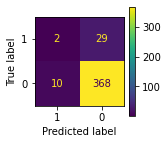

,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.167,0.065,0.093,0.905,0.686,0.079


In [11]:
print("############### Results without encoding ##############")
results1     = train_grid_XGB_model(train_set, valid_set, X_train_set, X_valid_set, grid, feat_list)

############### Results encoded data ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

Best: 0.143791 using {'batch_size': 60, 'dropout_rate': 0.2, 'epochs': 100}
AUC    (call)
0.708956 (0.013072) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 10}
0.629871 (0.098039) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 50}
0.631461 (0.111111) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 100}
0.702632 (0.013072) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 10}
0.646529 (0.111111) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 50}
0.635170 (0.130719) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 100}
0.714026 (0.013072) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10}
0.655503 (0.111111) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 50}
0.648490 (0.117647) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 100}
0.704416 (0.006536) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 10}
0.656863 (0.104575) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 50}
0.640894 (0.117647) with: {

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


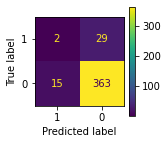

,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.118,0.065,0.083,0.892,0.602,0.098


In [12]:
print("############### Results encoded data ##############")
results1_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, X_train_set, X_valid_set, grid, feat_list)

# CURB65 Group 2

In [13]:
X_train_set = X_data_16_18[1]
X_valid_set = X_data_19_20[1]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1037
total admissions 19 20 389
X_train 1037
Admissions neg (mortal - class = 0): 926 Admissions pos (recover- class = 1): 111
X_valid 389
Admissions neg (mortal - class = 0): 328 Admissions pos (recover- class = 1): 61

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr_Peak,rr_Trough,ews_Peak,ews_Trough,heart_rate_Peak,heart_rate_Trough,temperature_Peak,temperature_Trough,sbp_Peak,...,Assisted_O2_Trough,Confusion_Peak,Confusion_Trough,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,97068612,20.000,16.000,2,0,98.941,85.542,37.576,36.407,163.250,...,1.000,1,1,1,0,84,0,1,1.000,0
1,73017510,22.667,17.062,10,0,81.786,58.000,37.464,35.812,136.929,...,1.000,1,0,-1,0,90,0,1,1.000,1
2,76521119,24.000,18.000,8,0,90.182,72.000,37.547,36.800,152.105,...,1.000,1,0,-1,0,72,9,0,0.000,1
3,92549820,22.000,15.444,7,0,92.000,79.692,37.200,36.000,160.000,...,1.000,1,0,-1,0,79,6,1,1.000,0


,rr_Peak,rr_Trough,ews_Peak,ews_Trough,heart_rate_Peak,heart_rate_Trough,temperature_Peak,temperature_Trough,sbp_Peak,sbp_Trough,...,Assisted_O2_Peak,Assisted_O2_Trough,Confusion_Peak,Confusion_Trough,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.879,-0.904,0.121,0.082,-0.252,0.956,-0.310,0.138,0.719,-0.342,...,1.000,1.000,1,1,1,0.114,0.616,-0.815,1,1.000
1,-0.346,-0.230,0.138,0.082,-1.213,-1.232,-0.463,-1.183,-0.544,-0.700,...,1.000,1.000,1,0,-1,0.114,1.150,-0.815,1,1.000
2,-0.080,0.364,0.127,0.082,-0.743,-0.120,-0.350,1.012,0.184,-0.208,...,1.000,1.000,1,0,-1,0.114,-0.451,0.841,0,0.000
3,-0.480,-1.256,0.094,0.082,-0.641,0.492,-0.823,-0.766,0.563,-0.192,...,1.000,1.000,1,0,-1,0.114,0.171,0.289,1,1.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr_Peak,rr_Trough,ews_Peak,ews_Trough,heart_rate_Peak,heart_rate_Trough,temperature_Peak,temperature_Trough,sbp_Peak,...,Assisted_O2_Trough,Confusion_Peak,Confusion_Trough,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,88572864,20.000,16.000,6,0,94.467,53.615,36.700,34.900,155.133,...,0.000,1,0,-1,1,93,6,1,1.000,1
1,62751181,28.000,20.000,7,2,114.667,90.000,39.000,36.500,146.000,...,1.000,1,0,1,0,67,0,0,1.000,0
2,21357495,24.000,16.000,3,0,105.000,60.167,38.383,36.233,150.000,...,0.000,1,0,-1,0,84,8,1,1.000,0
3,83262936,17.000,16.000,2,0,109.000,74.208,37.684,36.800,137.000,...,0.000,1,0,1,0,89,0,0,1.000,0


,rr_Peak,rr_Trough,ews_Peak,ews_Trough,heart_rate_Peak,heart_rate_Trough,temperature_Peak,temperature_Trough,sbp_Peak,sbp_Trough,...,Assisted_O2_Peak,Assisted_O2_Trough,Confusion_Peak,Confusion_Trough,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.879,-0.904,0.119,0.082,-0.503,-1.581,-1.505,-3.211,0.329,-1.007,...,1.000,0.000,1,0,-1,0.091,1.417,0.289,1,1.000
1,0.720,1.632,0.094,0.114,0.628,1.311,1.631,0.346,-0.109,-0.884,...,1.000,1.000,1,0,1,0.114,-0.896,-0.815,0,1.000
2,-0.080,-0.904,0.054,0.082,0.087,-1.060,0.790,-0.247,0.083,-0.132,...,0.000,0.000,1,0,-1,0.114,0.616,0.657,1,1.000
3,-1.479,-0.904,0.121,0.082,0.311,0.056,-0.163,1.012,-0.541,-0.047,...,0.000,0.000,1,0,1,0.114,1.061,-0.815,0,1.000


,feature,type,parameters
0,rr_Peak,Continuous,"[24.39865192328313, 5.001615874754787]"
1,rr_Trough,Continuous,"[17.426014479023358, 1.577292985855703]"
2,ews_Peak,Categorical,0 1 prob 2 58 8 0.121 10 50 ...
3,ews_Trough,Categorical,0 1 prob 0 404 36 0.082 2 256 33 0...
4,heart_rate_Peak,Continuous,"[103.4449977639402, 17.8558001777045]"
5,heart_rate_Trough,Continuous,"[73.50777322529359, 12.582750588068395]"
6,temperature_Peak,Continuous,"[37.803863338633896, 0.7334086112167629]"
7,temperature_Trough,Continuous,"[36.34453475267147, 0.4498807088481204]"
8,sbp_Peak,Continuous,"[148.2746121661516, 20.841410197930895]"
9,sbp_Trough,Continuous,"[106.39490583583947, 16.285345133177263]"


############### Results without encoding ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

Best: 0.087087 using {'batch_size': 60, 'dropout_rate': 0.2, 'epochs': 100}
AUC    (call)
0.609523 (0.006006) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 10}
0.656117 (0.000000) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 50}
0.645804 (0.000000) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 100}
0.617001 (0.006006) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 10}
0.659277 (0.000000) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 50}
0.654229 (0.009009) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 100}
0.621168 (0.015015) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10}
0.651942 (0.009009) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 50}
0.656065 (0.000000) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 100}
0.617033 (0.003003) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 10}
0.628555 (0.015015) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 50}
0.656993 (0.009009) with: {

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


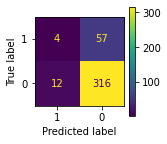

,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.250,0.066,0.104,0.823,0.584,0.142


In [14]:
print("############### Results without encoding ##############")
results2     = train_grid_XGB_model(train_set, valid_set, X_train_set, X_valid_set, grid, feat_list)

############### Results encoded data ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

Best: 0.162162 using {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 50}
AUC    (call)
0.690761 (0.018018) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 10}
0.618701 (0.153153) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 50}
0.627674 (0.126126) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 100}
0.692855 (0.030030) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 10}
0.630790 (0.162162) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 50}
0.624521 (0.144144) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 100}
0.699336 (0.009009) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10}
0.618303 (0.147147) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 50}
0.626895 (0.138138) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 100}
0.705419 (0.006006) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 10}
0.628393 (0.126126) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 50}
0.614542 (0.135135) with: {'

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


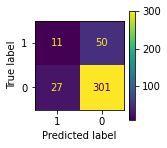

,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.289,0.180,0.222,0.802,0.561,0.177


In [15]:
print("############### Results encoded data ##############")
results2_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, X_train_set, X_valid_set, grid, feat_list)

# CURB65 Group 3

In [16]:
X_train_set = X_data_16_18[2]
X_valid_set = X_data_19_20[2]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1095
total admissions 19 20 259
X_train 1095
Admissions neg (mortal - class = 0): 898 Admissions pos (recover- class = 1): 197
X_valid 259
Admissions neg (mortal - class = 0): 206 Admissions pos (recover- class = 1): 53

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr_Peak,rr_Trough,ews_Peak,ews_Trough,heart_rate_Peak,heart_rate_Trough,temperature_Peak,temperature_Trough,sbp_Peak,...,Assisted_O2_Trough,Confusion_Peak,Confusion_Trough,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,79958796,26.000,18.000,10,2,107.389,68.000,38.300,36.200,154.342,...,1.000,1,0,-1,0,79,8,0,0.000,1
1,54340823,38.000,19.000,8,3,101.000,71.167,37.000,35.800,145.000,...,1.000,1,0,-1,0,91,0,1,1.000,1
2,53145905,22.000,16.000,5,0,95.000,69.071,37.000,35.833,118.000,...,1.000,1,0,-1,0,90,3,0,1.000,0
3,68698350,28.000,17.000,10,3,85.000,61.556,36.700,35.000,109.647,...,1.000,1,0,-1,0,80,2,1,0.000,0


,rr_Peak,rr_Trough,ews_Peak,ews_Trough,heart_rate_Peak,heart_rate_Trough,temperature_Peak,temperature_Trough,sbp_Peak,sbp_Trough,...,Assisted_O2_Peak,Assisted_O2_Trough,Confusion_Peak,Confusion_Trough,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,0.064,0.254,0.253,0.196,0.225,-0.296,0.678,-0.130,0.492,0.647,...,1.000,1.000,1,0,-1,0.177,-0.259,0.484,0,0.000
1,2.099,0.757,0.259,0.265,-0.107,-0.053,-0.999,-0.868,0.035,0.282,...,1.000,1.000,1,0,-1,0.177,1.111,-0.978,1,1.000
2,-0.614,-0.753,0.123,0.135,-0.419,-0.214,-0.999,-0.806,-1.286,-0.555,...,1.000,1.000,1,0,-1,0.177,0.997,-0.430,0,1.000
3,0.403,-0.250,0.253,0.265,-0.939,-0.790,-1.386,-2.343,-1.694,-2.364,...,1.000,1.000,1,0,-1,0.177,-0.145,-0.613,1,0.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr_Peak,rr_Trough,ews_Peak,ews_Trough,heart_rate_Peak,heart_rate_Trough,temperature_Peak,temperature_Trough,sbp_Peak,...,Assisted_O2_Trough,Confusion_Peak,Confusion_Trough,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,59603192,26.000,17.077,6,0,78.769,60.385,38.100,36.500,145.000,...,0.000,1,0,-1,0,84,12,0,1.000,0
1,33386907,18.000,16.000,2,0,87.000,69.000,36.900,36.400,144.000,...,0.000,1,0,1,0,88,3,1,0.000,0
2,80377128,22.000,17.000,6,0,87.000,66.462,36.600,35.841,135.000,...,0.000,1,0,1,0,84,4,1,1.000,1
3,26956465,24.000,18.000,3,0,95.800,81.333,37.200,36.435,180.250,...,0.000,1,0,1,11,94,0,0,0.000,0


,rr_Peak,rr_Trough,ews_Peak,ews_Trough,heart_rate_Peak,heart_rate_Trough,temperature_Peak,temperature_Trough,sbp_Peak,sbp_Trough,...,Assisted_O2_Peak,Assisted_O2_Trough,Confusion_Peak,Confusion_Trough,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,0.064,-0.211,0.182,0.135,-1.263,-0.880,0.420,0.423,0.035,0.599,...,1.000,0.000,1,0,-1,0.177,0.312,1.216,0,1.000
1,-1.292,-0.753,0.088,0.135,-0.835,-0.219,-1.128,0.238,-0.014,0.592,...,1.000,0.000,1,0,1,0.177,0.769,-0.430,1,0.000
2,-0.614,-0.250,0.182,0.135,-0.835,-0.414,-1.515,-0.792,-0.454,-0.486,...,1.000,0.000,1,0,1,0.177,0.312,-0.247,1,1.000
3,-0.275,0.254,0.136,0.135,-0.377,0.727,-0.741,0.303,1.760,0.893,...,0.000,0.000,1,0,1,0.000,1.454,-0.978,0,0.000


,feature,type,parameters
0,rr_Peak,Continuous,"[25.622196828914444, 5.897686533478105]"
1,rr_Trough,Continuous,"[17.496100661434756, 1.9873446349890136]"
2,ews_Peak,Categorical,0 1 prob 10 62 21 0.253 8 106 3...
3,ews_Trough,Categorical,0 1 prob 2 251 61 0.196 3 72 2...
4,heart_rate_Peak,Continuous,"[103.05985009535429, 19.236635630793824]"
5,heart_rate_Trough,Continuous,"[71.85664391768819, 13.035144415220659]"
6,temperature_Peak,Continuous,"[37.77451005909831, 0.7754361570347597]"
7,temperature_Trough,Continuous,"[36.270766890996875, 0.5424453129101484]"
8,sbp_Peak,Continuous,"[144.27788595581828, 20.43918854961775]"
9,sbp_Trough,Continuous,"[101.19408241066894, 16.577874186566373]"


############### Results without encoding ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

Best: 0.105180 using {'batch_size': 60, 'dropout_rate': 0.2, 'epochs': 50}
AUC    (call)
0.637610 (0.023932) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 10}
0.699936 (0.032194) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 50}
0.696769 (0.027091) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 100}
0.646294 (0.000000) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 10}
0.697141 (0.005076) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 50}
0.697199 (0.042347) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 100}
0.668427 (0.018519) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10}
0.684434 (0.035587) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 50}
0.685565 (0.054157) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 100}
0.642310 (0.033670) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 10}
0.685958 (0.057602) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 50}
0.698088 (0.020513) with: {'

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


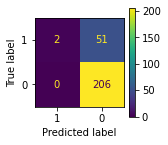

,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,1.000,0.038,0.073,0.803,0.692,0.151


In [17]:
print("############### Results without encoding ##############")
results3     = train_grid_XGB_model(train_set, valid_set, X_train_set, X_valid_set, grid, feat_list)

############### Results encoded data ##############


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

Best: 0.221575 using {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 50}
AUC    (call)
0.700202 (0.057602) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 10}
0.591743 (0.193007) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 50}
0.593320 (0.214918) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 100}
0.700588 (0.079565) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 10}
0.599724 (0.221575) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 50}
0.594757 (0.206527) with: {'batch_size': 10, 'dropout_rate': 0.5, 'epochs': 100}
0.707198 (0.045739) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 10}
0.610407 (0.187853) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 50}
0.586281 (0.203082) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 100}
0.704356 (0.060891) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 10}
0.610970 (0.201502) with: {'batch_size': 20, 'dropout_rate': 0.5, 'epochs': 50}
0.583719 (0.211707) with: {'

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


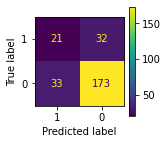

,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.389,0.396,0.393,0.749,0.630,0.200


In [18]:
print("############### Results encoded data ##############")
results3_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, X_train_set, X_valid_set, grid, feat_list)

# Results

# AUROC curve

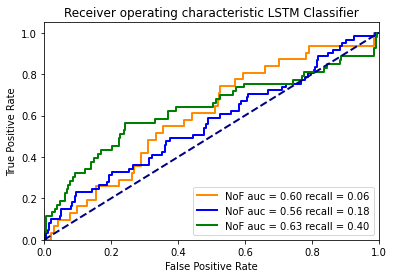

In [19]:
title = 'LSTM Classifier'
plt.figure()
colors = ['darkorange', 'b','g','r','c', 'm']
i = 0

results_encs =[results1_enc, results2_enc, results3_enc]

for results_enc in results_encs:

    df_results_valid = results_enc[1]
    dict_fpr_tpr     = results_enc[2]

    key = 'NoF'
    val = dict_fpr_tpr[key]
    auc = df_results_valid.loc[key,'AUC']
    rcl = df_results_valid.loc[key,'Recall']
    fpr, tpr = val

    lw = 2

    plt.plot(fpr,  tpr,  color= colors[i],  lw=lw,label= key + " auc = {:,.2f} recall = {:,.2f}".format(auc, rcl) 
        #label="ROC curve (area = %0.2f)" % metrics.roc_auc[2],
    )
    i = i + 1
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic "+ title)
plt.legend(loc="lower right")
#plt.savefig('AUROC_'+title+'.png', transparent = True, bbox_inches = "tight")
plt.show()

In [20]:
pickle.dump([results_encs], open('pnt_dict_fpr_trp_'+title+'.pickle', 'wb'))

In [21]:
for r in results_encs:
    display(r[1])

,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.118,0.065,0.083,0.892,0.602,0.098


,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.289,0.180,0.222,0.802,0.561,0.177


,Precision,Recall,F1_Score,Accuracy,AUC,brier
NoF,0.389,0.396,0.393,0.749,0.630,0.200


/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i

/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/d/dlr10/anaconda3/envs/spyder-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   i